In [9]:

import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [15]:
dataset = pd.read_csv("Airlines+Data.csv")
dataset.head()

,Month,Passengers
0,01-01-1995,112
1,01-02-1995,118
2,01-03-1995,132
3,01-04-1995,129
4,01-05-1995,121


In [16]:
# Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

In [17]:
from datetime import datetime
indexedDataset['1995-03']
indexedDataset['1995-03':'1995-06']
indexedDataset['1995']

C:\Users\user\AppData\Local\Temp/ipykernel_4040/2470722340.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  indexedDataset['1995-03']
C:\Users\user\AppData\Local\Temp/ipykernel_4040/2470722340.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  indexedDataset['1995']


,Passengers
Month,
1995-01-01,112
1995-01-02,118
1995-01-03,132
1995-01-04,129
1995-01-05,121
1995-01-06,135
1995-01-07,148
1995-01-08,148
1995-01-09,136


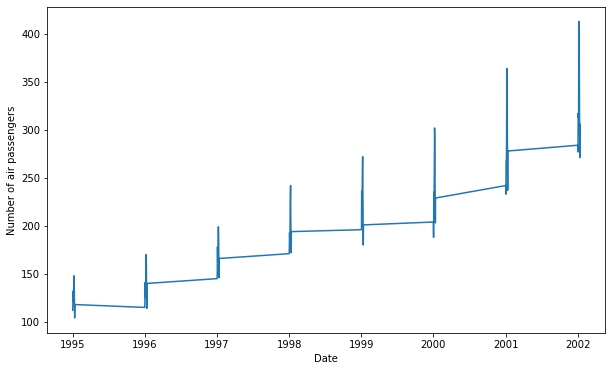

In [18]:
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
plt.plot(indexedDataset)

In [19]:
#Determing rolling statistics
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-01-02         NaN
1995-01-03         NaN
1995-01-04         NaN
1995-01-05         NaN
...                ...
2002-01-08  316.833333
2002-01-09  320.416667
2002-01-10  323.083333
2002-01-11  325.916667
2002-01-12  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-01-02         NaN
1995-01-03         NaN
1995-01-04         NaN
1995-01-05         NaN
...                ...
2002-01-08   54.530781
2002-01-09   55.586883
2002-01-10   53.899668
2002-01-11   49.692616
2002-01-12   47.861780

[96 rows x 1 columns]


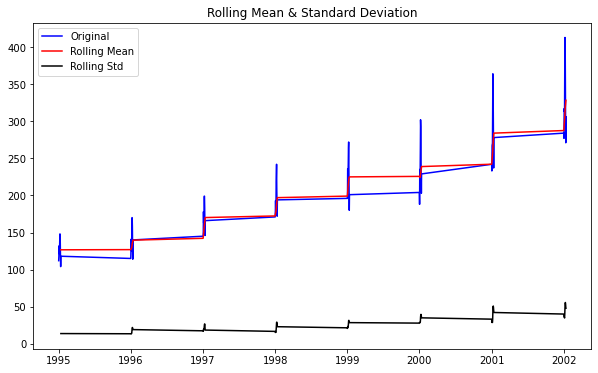

In [20]:
#Plot rolling statistics:
orig = plt.plot(indexedDataset, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


In [21]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


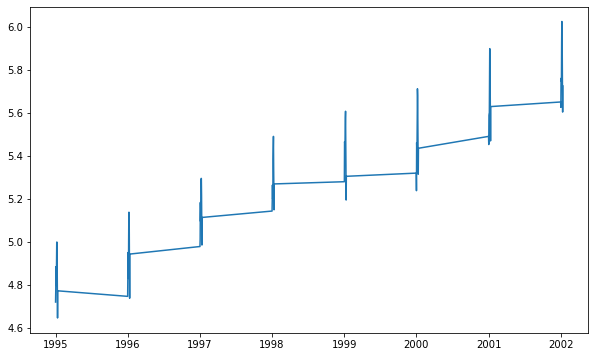

In [22]:
# Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

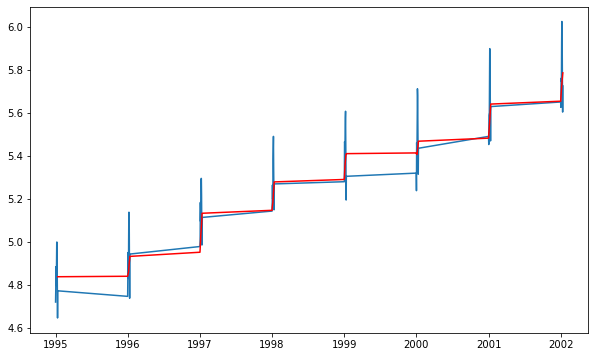

In [23]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [24]:
# Get the difference between the moving average and the actual number of passengers
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1995-01-12,-0.065494
1996-01-01,-0.093449
1996-01-02,-0.007566
1996-01-03,0.099416
1996-01-04,0.052142
1996-01-05,-0.027529
1996-01-06,0.139881
1996-01-07,0.260184
1996-01-08,0.248635


In [25]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

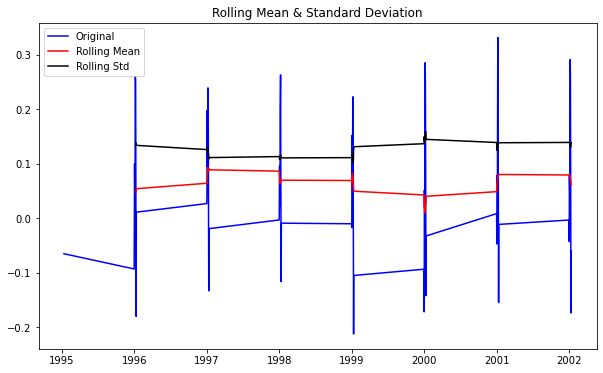

Results of Dickey-Fuller Test:
Test Statistic                 -1.910930
p-value                         0.326937
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [26]:
test_stationarity(datasetLogScaleMinusMovingAverage)


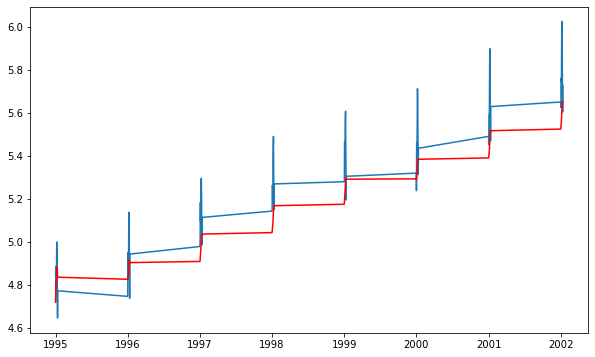

In [27]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

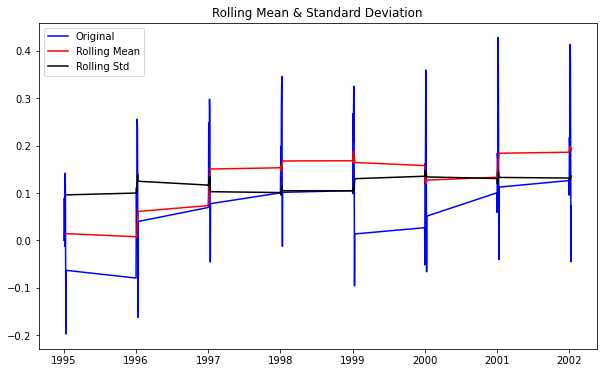

Results of Dickey-Fuller Test:
Test Statistic                 -2.835036
p-value                         0.053441
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [28]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

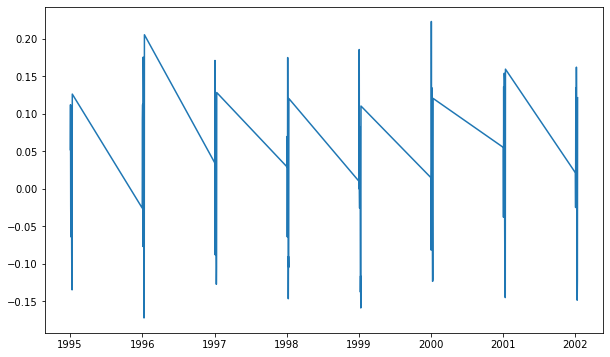

In [29]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

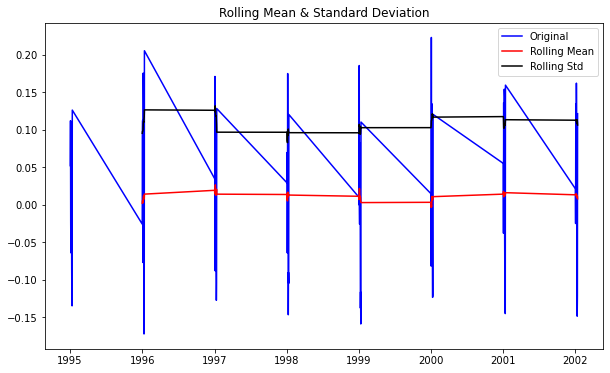

Results of Dickey-Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [30]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

C:\Users\user\AppData\Local\Temp/ipykernel_4040/2559380049.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(indexedDataset_logScale,freq=7)


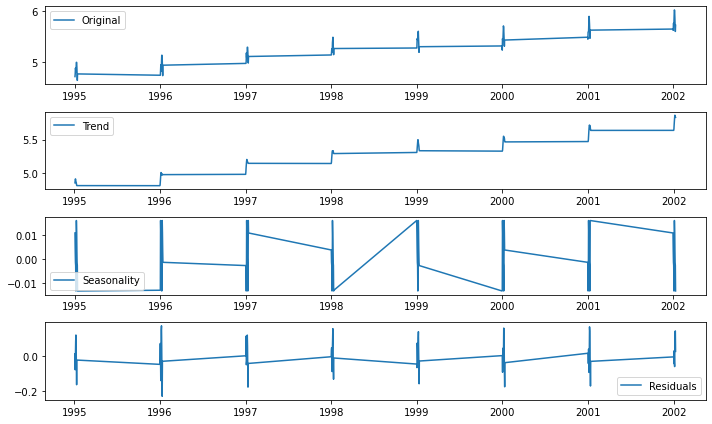

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(indexedDataset_logScale,freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


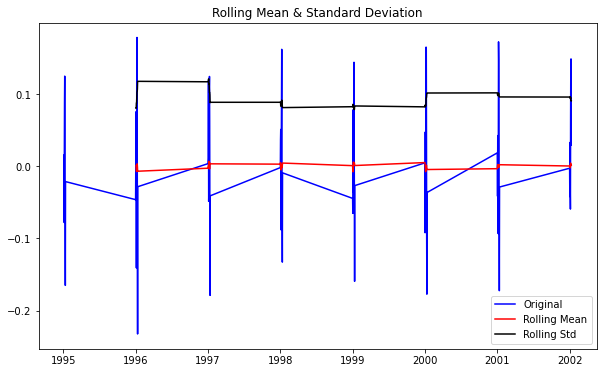

Results of Dickey-Fuller Test:


KeyError: 'Passengers'

In [39]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


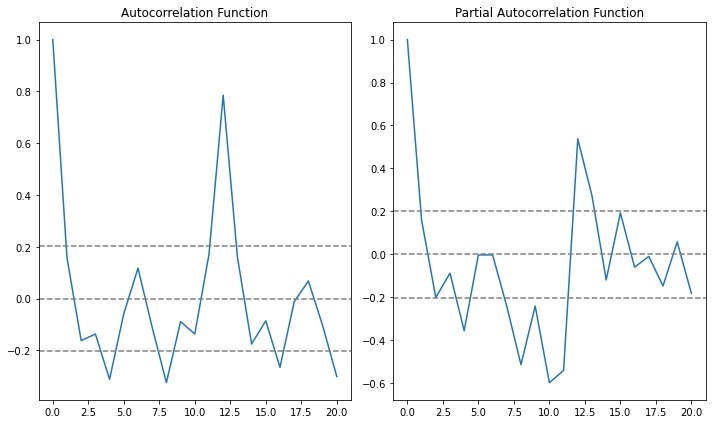

In [40]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')


#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no as

Plotting AR model


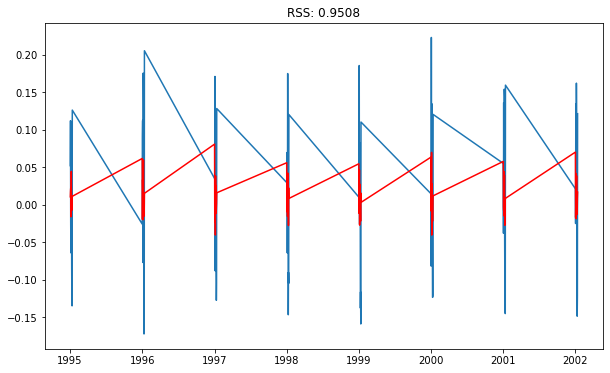

In [41]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset_logScale, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting AR model


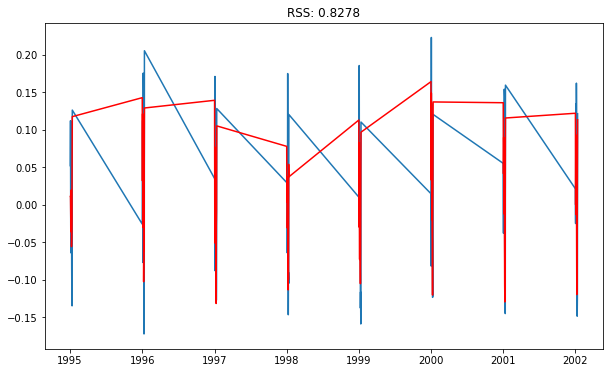

In [42]:
#MA MODEL
model = ARIMA(indexedDataset_logScale, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\user\newfolder\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\user\n

Text(0.5, 1.0, 'RSS: 0.6931')

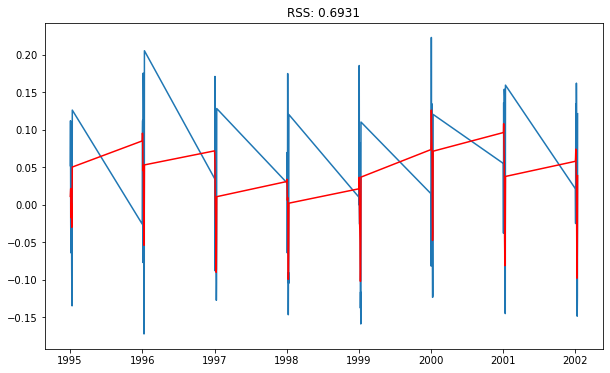

In [43]:
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1995-01-02    0.011261
1995-01-03    0.016603
1995-01-04    0.021664
1995-01-05   -0.008096
1995-01-06   -0.017396
dtype: float64


In [45]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1995-01-02    0.011261
1995-01-03    0.027864
1995-01-04    0.049527
1995-01-05    0.041431
1995-01-06    0.024035
dtype: float64


In [46]:
#predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'], index=indexedDataset_logScale['Passengers'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1995-01-01    4.718499
1995-01-02    4.781946
1995-01-03    4.910666
1995-01-04    4.909340
1995-01-05    4.837222
dtype: float64

Text(0.5, 1.0, 'RMSE: 221.4947')

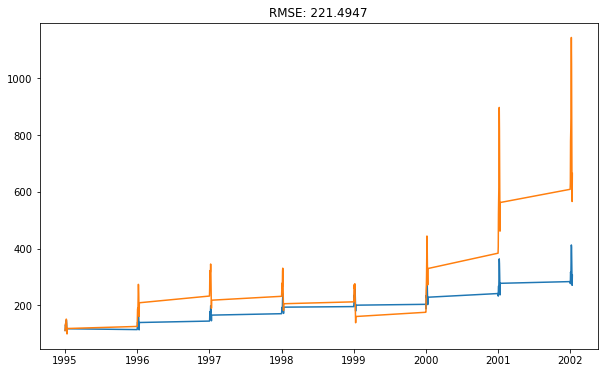

In [47]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset["Passengers"])**2)/len(indexedDataset["Passengers"])))